## Import

In [1]:
import math
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':180, # 90일치로 학습
    'PREDICT_SIZE':34, # 21일치 예측
    'EPOCHS':20,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':64,
    'SEED':41,
    'num_workers':6
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [5]:
train_data = pd.read_csv('./data/train.csv').drop(columns=['제품'])
brand_keyword_cnt = pd.read_csv('./data/brand_keyword_cnt.csv')
product_info = pd.read_csv('./data/product_info.csv')
sales = pd.read_csv('./data/sales.csv')

### 데이터 전처리

In [6]:
# Data Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train_data))):
    maxi = np.max(train_data.iloc[idx,5:])
    mini = np.min(train_data.iloc[idx,5:])
    
    if maxi == mini :
        train_data.iloc[idx,5:] = 0
    else:
        train_data.iloc[idx,5:] = (train_data.iloc[idx,5:] - mini) / (maxi - mini)
    
    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

  0%|          | 0/15890 [00:00<?, ?it/s]

In [7]:
train_data['ID'] = train_data['ID'].astype(int)
train_data['대분류'] = train_data['대분류'].str.split('-').str.get(2)
train_data['중분류'] = train_data['대분류']+'-'+train_data['중분류'].str.split('-').str.get(2)
train_data['소분류'] = train_data['중분류']+'-'+train_data['소분류'].str.split('-').str.get(2)
train_data['브랜드'] = train_data['소분류']+'-'+train_data['브랜드'].str.split('-').str.get(1)
train_data.head(2)

,ID,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0002,0002-0007,0002-0007-0038,0002-0007-0038-00001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,1,0003,0003-0008,0003-0008-0044,0003-0008-0044-00002,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.0,0.0,0.222222,0.0


In [8]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [9]:
train_data.head(1)

,ID,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,1,7,39,3906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data = train_data
train_size=CFG['TRAIN_WINDOW_SIZE'] #90일치 학습
predict_size=CFG['PREDICT_SIZE']    #21일치 예측
print(train_size,predict_size)

180 34


In [12]:
data1 = data[data['대분류']==0]
data2 = data[data['대분류']==1]
data3 = data[data['대분류']==2]
data4 = data[data['대분류']==3]
data5 = data[data['대분류']==4]

In [13]:
len(data1),len(data2),len(data3),len(data4),len(data5)

(3768, 10954, 444, 111, 613)

In [46]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [47]:
data1_cut = data1.iloc[:,5:418].sum()/len(data1)

In [48]:
data_train = data1_cut.iloc[:-34].to_numpy()
data_test = data1_cut.iloc[-34:].to_numpy()

In [49]:
iw = 90
ow = 34

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

### 모델 선언

In [50]:
"""
iw: input window
ow: output window

"""
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [51]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(iw, ow, 512*2, 8, 4, 0.1).to(device) # iw, ow, d_model, nhead, nlayers, dropout=0.5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [52]:
epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
def evaluate():
    input = torch.tensor(data_train[-iw:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [54]:
result = evaluate()

In [55]:
result

array([[0.12839657, 0.12745216, 0.12439932, 0.12256508, 0.12614979,
        0.13024734, 0.1265706 , 0.11845784, 0.13002937, 0.12196165,
        0.11522965, 0.11756884, 0.13191491, 0.1304251 , 0.12674813,
        0.1197114 , 0.12041409, 0.12190621, 0.11908861, 0.12625483,
        0.12805061, 0.12812382, 0.12443739, 0.11757936, 0.12857702,
        0.11950687, 0.12873784, 0.1255888 , 0.12009022, 0.126137  ,
        0.12182646, 0.12864488, 0.1254696 , 0.12380847]], dtype=float32)

In [53]:
len(data1_cut)

413

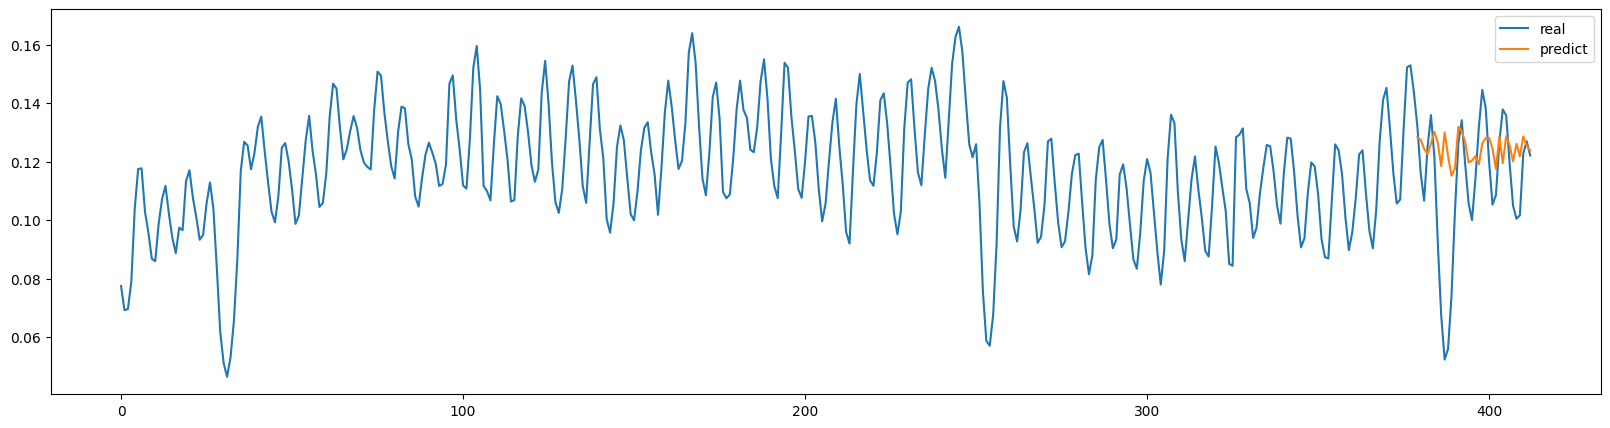

In [58]:
plt.figure(figsize=(20,5))
plt.plot(range(413),data1_cut, label="real")
plt.plot(range(413-34,413),result[0], label="predict")
plt.legend()
plt.show()